# Restricted Boltzmann Machines

Group 2314:
- Gloria Isotton   ID: 2072705
- Sara Munafò      ID: 2072380
- Maryam Feizi     ID: 2091504
- Carlo Divari     ID: 1186975

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14
import seaborn as sns
from numba import jit, prange

In [2]:
dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'

v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)

N = len(v)
L = len(v[1])

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

print(v.shape)

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...
(10000, 20)


## Initialize

In [3]:
M=2
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
#print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

In [4]:
class Data():
    pass
d = Data()
d.w = w
d.a = a
d.b = b
d.v = v
d.GAP = GAP

## Plotting

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


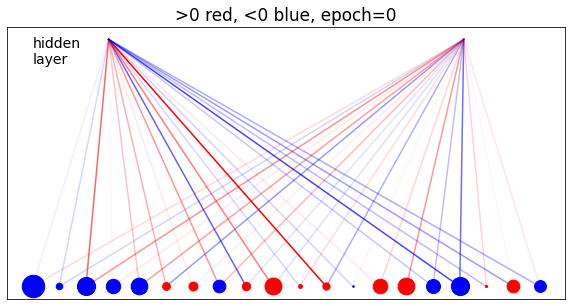

In [5]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./d.w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(d.w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(d.w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(d.a.max()+d.b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(d.a[i]), zorder=2, c=mycolor(d.a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(d.b[j]), zorder=2, c=mycolor(d.b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()

def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(d.w.max(),-d.w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(d.w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(d.w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(d.a[i]), zorder=2, c=mycolor(d.a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(d.b[j])), zorder=2, c=mycolor(d.b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph()

In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

k = 4
activate(v[k],w,b,GAP,info=True)

input= [0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
act= [-0.26465979  1.34505401]
prob= [0.43421858 0.79331984]
output= [0 0]


array([0, 0])

# Backward activation function for one-hot encoded structure

If we use the sigmoid as activation function for the backward step of contrastive divergence, for each 4 blocks of the vector there are $2^4$ possible states, while for the way in which our data is structured (one-hot encoding) the ''real'' possible states are only 4: 0001,0010,0100,1000.    

With the new activation function, we take into consideration the energies associated with each possible state, compute the associated probabilities, and generate 4 blocks at a time of the new "fantasy" vector according to in which interval a random number between 0 and 1 is generated. In this way, we preserve the one-hot encoding structure of the original data.

In [7]:
s = np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

def activate_back(v,h,w,a,k,steps,info=False):
    
    e = np.zeros(4)
    cprob = np.zeros(4)
    vf = np.zeros(20)
    
    for i in range(0,20,4):
        for j in range(len(s)):
            if np.array_equiv(v[i:i+4],s[j])==True:
                local_f = a[i:i+4]+np.dot(w[i:i+4,:],h)
                e[j]+= np.dot(local_f,v[i:i+4])
     
    bol = np.zeros(4)
    for i in range(len(s)):
        if e[i]!=0:
            bol = exp(-e)
            
    p = bol/bol.sum()

    cprob[0] = p[0]
    for i in range(1,4):
        cprob[i]+=cprob[i-1]+p[i]
        
    for i in range(0,20,4):
        x = np.random.random()
        if x<=cprob[0]:
            vf[i:i+4]=s[0]
        elif x<=cprob[1]:
            vf[i:i+4]=s[1]
        elif x<=cprob[2]:
            vf[i:i+4]=s[2]
        else: 
            vf[i:i+4]=s[3]
            
    #for i in range(0,3):
        #if k == 500*i and steps==1 and info==True:
           # print('----initiating backward CD: k = ',k,'----')
            #print('WEIGHTS[0] : ', w.T[0])
            #print('EVALUATED ENERGIES = ',e, '\n') 
            #print('PROBABILITY : ', p, '\n')                       
            #print('CUMULATIVE PROBABILITY : ', cprob, '\n\n')
            
    return(vf,cprob)



# Indicators of performance

In order to have a better idea of how our RBM is performing, we implement the following indicators:
- Energy gap between the states generated by the RBM and the original states
- Second moment
- Log-Likelihood
- Adversarial accuracy

## Energy of RBM

In [8]:
def E(v,h):
    ene = -(np.dot((np.dot(v,w)).T,h))-np.dot(a.T,v)-np.dot(b.T,h)
    return ene

## Second Moment

In [9]:
cov_data = np.cov(d.v)/N

def sec_mom(Vf,N,L,cov_data):
    cov_sum = 0
    cov_vf = np.cov(Vf)
    for j in range(0,N):
        for i in range(0, j):
            cov_sum+=(cov_vf[i,j]-cov_data[i,j])**2
    return (cov_sum*2)/(L*(L-1))

## Log-Likelihood

In [10]:
A = 4
G = 5
def energy(v,h,d):
    eng = - np.dot(d.a,v) - np.dot(d.b,h) - np.dot(v.T@d.w,h)
    return eng

def Z(v,h,d):
    print('un secondo')
    z=0
    for iI,i in enumerate(v):
        for jJ, j in enumerate(h):
             z+=np.exp(-energy(i,j,d))
    return z

def P(v,h,d):
    p=0
    print("Ci siamo quasi")
    for Ii,i in enumerate(v):
        
        h_sum=0
        for jJ,j in enumerate(h):
            h_sum += np.exp(-energy(i,j,d))
        p += np.log(h_sum)
    dist= p/v.shape[0]
    return dist
            
def log_likelihood(v,h,d):
    print('iniziamo')
    L = P(v,h,d) -np.log(Z(v,h,d))
    return L


## Adversarial accuracy indicator

In [11]:
def distance(v1,v2):
    dist=[]
    if np.array_equiv(v1,v2)==True:
        for i in range(v1.shape[0]):
            print('riga:',i)
            dmin = 1e8
            for j in range(v1.shape[0]):
                if j!=i:
                    d = np.linalg.norm(v1[i] - v1[j])
                    if d<dmin:
                        dmin = d
            dist.append(dmin)
            print(dmin)
             
    else:
        for i in range(v1.shape[0]):
            print('riga__:',i)
            dmin = 1e8
            for j in range(v2.shape[0]):
                d = np.linalg.norm(v1[i] - v2[j])
                if d<dmin:
                    dmin = d
            dist.append(dmin)
            print(dmin)
    return(dist)     

def AAI(d1,d2,d3,d4): #DST-DSS-DTS-DTT
    A12 = d1-d2
    print(A12.shape)
    a12 = A12[A12>0]
    A_fin_12 = len(a12)/N
    A34 = d3-d4
    print(A34.shape)
    a34 = A34[A34>0]
    A_fin_34 = len(a34)/N
    aai = (A_fin_12-0.5)**2+(A_fin_34-0.5)**2
    return aai

# Optimizers

As the vanilla gradient descent didn't work well with our code, we directly implemented two different optimizers:
- ADAM
- RMSprop

### ADAM

In [12]:
class Optimizers():
    pass
opt = Optimizers()
opt.beta1 = 0.9
opt.beta2 = 0.999
opt.beta = 0.9
opt.epsilon=1e-8
opt.m_dw, opt.v_dw = 0, 0 
opt.m_db, opt.v_db = 0, 0
opt.m_da, opt.v_da = 0, 0

In [13]:
def opt_adam(t,opt,d,dw,db,da,l_rate_m):
    ##********update***********#
    opt.m_dw = opt.beta1*opt.m_dw + (1-opt.beta1)*dw
    opt.m_db = opt.beta1*opt.m_db + (1-opt.beta1)*db
    opt.m_da = opt.beta1*opt.m_da + (1-opt.beta1)*da
    ## rms beta 2
    opt.v_dw = opt.beta2*opt.v_dw + (1-opt.beta2)*(dw**2)
    opt.v_db = opt.beta2*opt.v_db + (1-opt.beta2)*(db**2)
    opt.v_da = opt.beta2*opt.v_da + (1-opt.beta2)*(da**2)
    ## bias correction
    m_dw_corr = opt.m_dw/(1-opt.beta1**t)
    m_db_corr = opt.m_db/(1-opt.beta1**t)
    m_da_corr = opt.m_da/(1-opt.beta1**t)
    v_dw_corr = opt.v_dw/(1-opt.beta2**t)
    v_db_corr = opt.v_db/(1-opt.beta2**t)
    v_da_corr = opt.v_da/(1-opt.beta2**t)
     ## update weights and biases
    d.w = d.w - l_rate_m*(m_dw_corr/(np.sqrt(v_dw_corr)+opt.epsilon))
    d.b = d.b - l_rate_m*(m_db_corr/(np.sqrt(v_db_corr)+opt.epsilon))
    d.a = d.a - l_rate_m*(m_da_corr/(np.sqrt(v_da_corr)+opt.epsilon))
    
    return (d.w,d.b,d.a)
                   

### RMSprop

In [14]:
def opt_rms(d,opt,dw,db,da,l_rate_m):
    opt.v_dw = opt.beta*opt.v_dw + (1-opt.beta)*(dw**2)
    opt.v_db = opt.beta*opt.v_db + (1-opt.beta)*(db**2)
    opt.v_da = opt.beta*opt.v_da + (1-opt.beta)*(da**2)
    d.w = d.w - l_rate_m*((dw)/(np.sqrt(opt.v_dw+opt.epsilon)))
    d.b = d.b - l_rate_m*((db)/(np.sqrt(opt.v_db+opt.epsilon)))
    d.a = d.a - l_rate_m*((da)/(np.sqrt(opt.v_da+opt.epsilon)))
    return (d.w,d.b,d.a)

# Training function

For the training, our idea is that to try different optimizers and tune parameters such as the learning rate and the mini-batch.
To make this process easier, we implemented a function for training.

In [15]:
np.random.seed(12345)

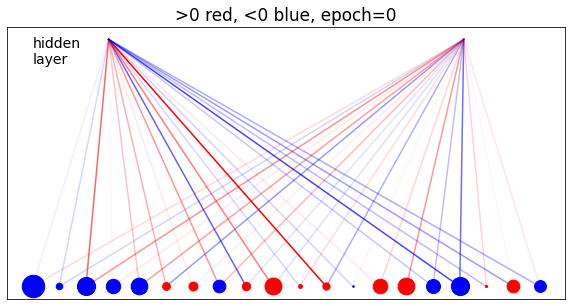

In [16]:
plotgraph(0)
N = 10000
L = 20
M = 2

In [17]:
def training(n_ad,epochs,cd_steps,l_rate,M,mini,opt,d,N,L,cov_data,SPINS):
    
    if SPINS:
        # sigmoid takes into account energy difference =2
        d.GAP=2
        # convert 0,1 -> -1,1
        d.v = 2*d.v - 1
        vmin=-1
        s = np.array([[-1,-1,-1,1],[-1,-1,1,-1],[-1,1,-1,-1],[1,-1,-1,-1]])
    else:
        d.GAP=1
        vmin=0
        s = np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
    
    t=1
    m = 0
    
    LL=[]
    V =  []
    H =  []
    
    second_mom = np.zeros(epochs)
    E_rbm = np.zeros(epochs)
    E_d = np.zeros(epochs)
    
    print('===================================================')
    for epoch in range(epochs):
         # aggregate normalization of batch statistics and learning rate
        l_rate_m = l_rate / mini
        
        for k in range(int(N)):
            if m==0:
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L),np.zeros(L)
                h_data, h_model = np.zeros(M),np.zeros(M)
                vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

            # positive CD phase: generating h 
            h = activate(d.v[k],d.w,d.b,d.GAP)
            hf = h
            vf = d.v[k]
            for i in range(cd_steps):                 #Contrastive Divergence
                vf,_ = activate_back(vf,hf,d.w,d.a,k,i)
                hf = activate(vf,d.w,d.b,d.GAP)
            v_data  += d.v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(d.v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            V.append(vf)
            H.append(h)
        
            # update energies of the state for each row
            E_rbm[epoch] += E(vf,h)/mini
            E_d[epoch] += E(d.v[k],h)/mini
    
            m += 1
        
            # minibatch
            if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a Adam optimizer
                dw = (vh_data - vh_model)
                da = (v_data - v_model)       
                db = (h_data - h_model)
            
                if epoch<=n_ad: #ADAM
                    d.w,d.b,d.a = opt_adam(t,opt,d,dw,db,da,l_rate_m)
                    
                    m = 0
                    t += 1 #update the time
                   
                else: #RMSprop
                    d.w,d.b,d.a = opt_rms(d,opt,dw,db,da,l_rate_m)

                    m = 0
            
            #if epoch%10==9 and k<=mini:
                #print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                #print('dw =',dw)
                #print('da =',da)
               # print('db =',db)
                #print('vh_data \n', vh_data, '\n')
                #print('vh_model \n',vh_model)
        Vf = np.array(V)     
        Hf = np.array(H)     
        #print(Vf)

        if epoch%10==9:
            LL.append(log_likelihood(Vf,Hf,d))
        V = []
        H = []
        #second momentum:
        #print(H)
        second_mom[epoch] = sec_mom(Vf,N,L,cov_data)

        # randomize the order of input data
        np.random.shuffle(d.v)
    
        l_rate = l_rate / (0.01 * l_rate + 1)
        if epoch%10==9:
            plotgraph(epoch+1)
            print('l_rate = ',l_rate)
        
    return(Vf,d.w,d.a,d.b,second_mom,E_rbm,E_d,second_mom,LL) 

# 0. CHOOSING REPRESENTATION OF DATA

First of all, we have to know if our RMB performs better (the weight are easier to understand) if the data is represented as a series of combinations of $0$s and $1$s or $1$s and $-1$s.     
This is taken into account by the parameter SPINS.    
In this case we are not interested in the best performance, but just in seeing the difference between the two, so the choice of the optimizer is not so relevant. We chose to use ADAM.

In [ ]:
Vf,w,a,b,_,_,_,_ = training(100,100,3,1.0,M,500,opt,d,N,L,cov_data,SPINS=False)

In [ ]:
#SPINS=False, opt=ADAM
np.savetxt('Vf_01.txt',Vf_01) 
np.savetxt('w_01.txt',w_01)
np.savetxt('a_01.txt',a_01)
np.savetxt('b_01.txt',b_01)


In [ ]:
Vf,w,a,b,_,_,_,_ = training(100,100,3,1.0,M,500,opt,d,N,L,cov_data,SPINS=True)

In [ ]:
#SPINS=True, opt=ADAM
np.savetxt('Vf_spins.txt',Vf)
np.savetxt('w_spins.txt',w)
np.savetxt('a_spins.txt',a)
np.savetxt('b_spins.txt',b)

## Visualizing the weights

From the pots above, the connections between visible and hidden units seem to be more clear in the case of the 0,1 encoding (difference in strongness are more noticeable).
This was expected, as the values -1,1 can alter too much the value of the energies computed in the function activate_back,, therefore giving not so representative values of the probabilities.
From now on, we work with (0,1) data.

In [ ]:
w_01 = np.loadtxt('w_01.txt')
w_spins = np.loadtxt('w_spins.txt')

In [ ]:
def reshaped(w,M):
    w1=[w[:,i].reshape(4,5) for i in range(M)]
    return w1
w_01r = reshaped(w_01,M)
w_spinsr = reshaped(w_spins,M)

fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(12,10))
for i in range(M):
    sns.heatmap(w_01r[i], cmap='coolwarm', annot=False, ax=axs.flat[i])
    axs.flat[i].set_title(f'Hidden Unit {i+1}(0,1)')
for i in range(2,4):
    sns.heatmap(w_spinsr[i-2], cmap='coolwarm', annot=False, ax=axs.flat[i])
    axs.flat[i].set_title(f'Hidden Unit {i-1}(-1,1)')

plt.show()


## Testing Log likelihood

[[0. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]]
[[0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ...

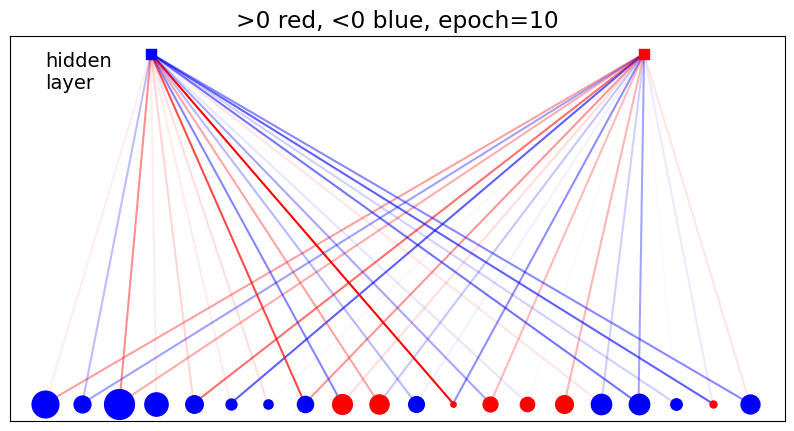

l_rate =  0.9090909090909092
[[1. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]]
[[0. 1. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]]
[[0. 0. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0.

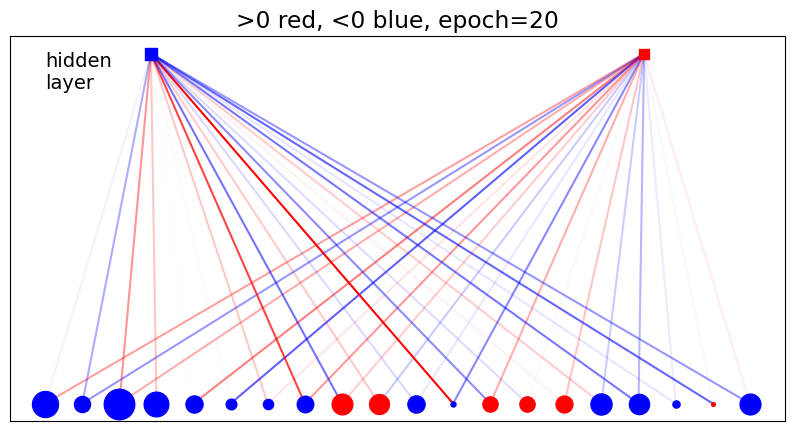

l_rate =  0.8333333333333337
[[0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]]
[[1. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]]
[[0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]]
[[1. 0. 0. ... 1. 0. 0.]
 [0. 1. 0.

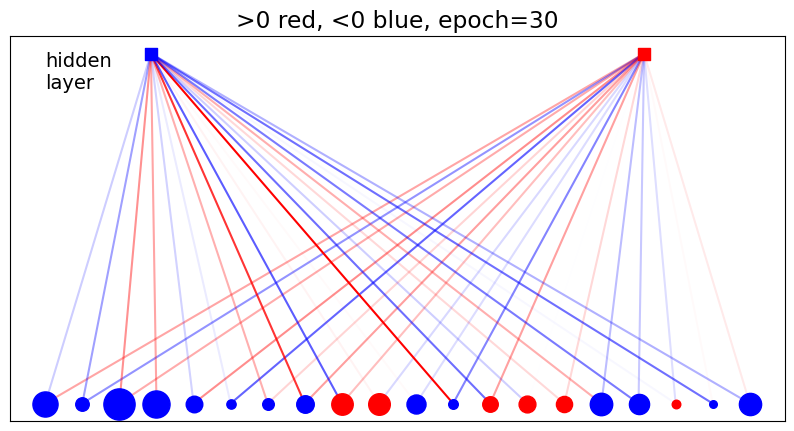

l_rate =  0.7692307692307697


In [37]:
Vf,d.w,d.a,d.b,second_mom, Log= training(200,200,3,1.0,2,500,opt,d,N,L,cov_data,SPINS=False)

In [46]:
print(Log)

[-9.43521265609743, -9.468122561147087, -9.557171237028259]


In [53]:
epochs=np.linspace(10,30,3)

In [54]:
epochs

array([10., 20., 30.])

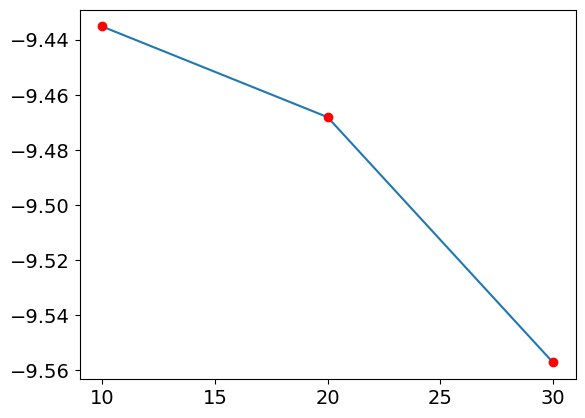

In [55]:
plt.plot(epochs,Log)
plt.plot(epochs,Log,'ro')

# 1. CHOOSING THE OPTIMIZER

## 1.1 ADAM + RMSprop

In [ ]:
Vf,d.w,d.a,d.b,E_rbm_ar,E_d_ar,second_mom_ar, Log_ar= training(120,200,3,1.0,2,500,opt,d,N,L,cov_data,SPINS=False)

In [ ]:
np.savetxt('Vf_ar.txt',Vf_ar)
np.savetxt('E_d_ar.txt',E_d_ar)
np.savetxt('E_rbm_ar.txt',E_rbm_ar)
np.savetxt('2mom_ar.txt',second_mom_ar)
np.savetxt('w_ar.txt',w_ar)
np.savetxt('a_ar.txt',a_ar)
np.savetxt('b_ar.txt',b_ar)
np.savetxt('Log_ar.txt',Log_ar)

In [ ]:
Vf_ar = np.loadtxt('Vf_ar.txt')
E_d_ar= np.loadtxt('E_d_ar.txt')
E_rbm_ar = np.loadtxt('E_rbm_ar.txt')
mom_ar = np.loadtxt('2mom_ar.txt')
Log_ar = np.loadtxt('Log_ar.txt')
epochs = 200

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(np.arange(200), E_d_ar, label='Data energy', color='navy')
ax.plot(np.arange(200), E_rbm_ar, label='RBM energy', color='indianred')
ax.legend(loc='best')

In [ ]:
dST_ar = distance(v0,Vf_ar)    
dSS_ar = distance(v0,v0)    
dTS_ar = distance(Vf_ar,v0) 
dTT_ar = distance(Vf_ar,Vf_ar)    
Accuracy_ar=AAI(dST_ar,dSS_ar,dTS_ar,dTT_ar)
print(Accuracy_ar)

## 1.2 ADAM

In [ ]:
Vf_a,w_a,a_a,b_a,E_rbm_a,E_d_a,second_mom_a,Log_a = training(200,200,3,1.0,2,500,opt,d,N,L,cov_data,SPINS=False)

In [ ]:
np.savetxt('Vf_a.txt',Vf_a)
np.savetxt('E_d_a.txt',E_d_a)
np.savetxt('E_rbm_a.txt',E_rbm_a)
np.savetxt('2mom_a.txt',second_mom_a)
np.savetxt('w_a.txt',w_a)
np.savetxt('a_a.txt',a_a)
np.savetxt('b_a.txt',b_a)
np.savetxt('Log_a.txt',Log_a)

In [ ]:
Vf_a = np.loadtxt('Vf_a.txt')
E_d_a = np.loadtxt('E_d_a.txt')
E_rbm_a = np.loadtxt('E_rbm_a.txt')
mom_a = np.loadtxt('2mom_a.txt')
Log_a = np.loadtxt('Log_a.txt')
epochs = 200

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(np.arange(epochs), E_d_a, label='Data energy', color='navy')
ax.plot(np.arange(epochs), E_rbm_a, label='RBM energy', color='indianred')
ax.legend(loc='best')

In [ ]:
dST_a = distance(v0,Vf_a)    
dSS_a = distance(v0,v0)    
dTS_a = distance(Vf_a,v0) 
dTT_a = distance(Vf_a,Vf_a)    
Accuracy_a=AAI(dST_a,dSS_a,dTS_a,dTT_a)
print(Accuracy_a)

## 1.3 RMSprop

In [ ]:
Vf_r,w_r,a_r,b_r,E_rbm_r,E_d_r,second_mom_r,Log_r = training(-1,200,3,1.0,2,500,opt,d,N,L,cov_data,SPINS=False)

In [ ]:
np.savetxt('Vf_r.txt',Vf_r)
np.savetxt('E_d_r.txt',E_d_r)
np.savetxt('E_rbm_r.txt',E_rbm_r)
np.savetxt('2mom_r.txt',second_mom_r)
np.savetxt('w_r.txt',w_r)
np.savetxt('a_r.txt',a_r)
np.savetxt('b_r.txt',b_r)
np.savetxt('Log_r.txt',Log_r)

In [ ]:
Vf_r = np.loadtxt('Vf_r.txt')
E_d_r= np.loadtxt('E_d_r.txt')
E_rbm_r = np.loadtxt('E_rbm_r.txt')
mom_r = np.loadtxt('2mom_r.txt')
Log_r = np.loadtxt('Log_r.txt')
epochs = 200

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(np.arange(epochs), E_d_r, label='Data energy', color='navy')
ax.plot(np.arange(epochs), E_rbm_r, label='RBM energy', color='indianred')
ax.legend(loc='best')

In [ ]:
dST_r = distance(v0,Vf_r)    
dSS_r = distance(v0,v0)    
dTS_r = distance(Vf_r,v0) 
dTT_r = distance(Vf_r,Vf_r)    
Accuracy_r=AAI(dST_r,dSS_r,dTS_r,dTT_r)
print(Accuracy_r)

# Evaluating performance

In [ ]:
#weights

In [ ]:
def reshaped(w,M):
    w1=[w[:,i].reshape(4,5) for i in range(M)]
    return w1
all_w = np.array[[reshaped(w_ar,M),reshaped(w_a,M),reshaped(w_r,M)]]

import seaborn as sns

fig, axs = plt.subplots(ncols=3,nrows=3 figsize=(5*6,4))
axs[0,:].set.title('Adam+RMSprop')
axs[1,:].set.title('Adam')
axs[2,:].set.title('RMSprop')
for j in range(3):
    for i in range(M):
        sns.heatmap(all_w[j][i], cmap='coolwarm', annot=False, ax=axs[i])
        axs[i].set_title(f'Hidden Unit {i+1}')
        plt.tight_layout()
    plt.show()

In [ ]:
#second momentum

In [ ]:
fig, ax = plt.subplots(figsize(10,7))
ax.plot(np.arange(epochs), mom_ar, label='Adam+RMSprop', color='indianred')
ax.plot(np.arange(epochs), mom_a, label='Adam', color='navy')
ax.plot(np.arange(epochs), mom_r, label='RMSprop', color='orange')
ax.set_xlabel('Epochs')
ax.set_ylabel('$\epsilon ^{(2)}$')

In [ ]:
#percentage

In [ ]:
import pandas as pd
percentages = pd.DataFrame([perc_ar[100],perc_a[100],perc_r[100]], columns=['Adam+RMSprop','Adam','RMSprop'])
percentages

# 2. CHOOSING THE MINI-BATCH SIZE

## 2.1 Mini-batch = 500

In [ ]:
#Take the results from before with the best optimizer

## 2.2 Mini-batch = 300

In [ ]:
Vf_3,w_3,a_3,b_3,E_rbm_3,E_d_3,second_mom_3,perc_3 = training(60,100,3,1.0,3,300,ad,d,0.9,N,L,cov_data)

## 2.3 Mini-batch = 1000

In [ ]:
Vf_10,w_10,a_10,b_10,E_rbm_10,E_d_10,second_mom_10,perc_10 = training(60,100,3,1.0,3,1000,ad,d,0.9,N,L,cov_data)

# Evaluating performance

In [ ]:
w1=[w[:,i].reshape(4,5) for i in range(M)]
import seaborn as sns

fig, axs = plt.subplots(ncols=3,nrows=3 figsize=(5*6,4))
axs[0,:].set.title('Adam+RMSprop')
axs[1,:].set.title('Adam')
axs[2,:].set.title('RMSprop')
for i in range(M):
    sns.heatmap(w1[i], cmap='coolwarm', annot=False, ax=axs[i])
    axs[i].set_title(f'Hidden Unit {i+1}')
    plt.tight_layout()
plt.show()

In [ ]:
#second momentum

In [ ]:
fig, ax = plt.subplots(figsize(10,7))
ax.plot(np.arange(epochs), second_mom_5, label='mini-batch=500', color='darkcyan')
ax.plot(np.arange(epochs), second_mom_3, label='mini-batch=300', color='cyan')
ax.plot(np.arange(epochs), second_mom_10, label='mini-batch=1000', color='darkslategrey')
ax.set_xlabel('Epochs')
ax.set_ylabel('$\epsilon ^{(2)}$')

In [ ]:
#percentage

In [ ]:
import pandas as pd
percentages = pd.DataFrame([perc_5[100],perc_3[100],perc_10[100]], columns=['mini-batch=500','mini-batch=300','mini-batch=1000'])
percentages